In [1]:
!nvidia-smi

Sat May 15 09:49:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip uninstall -y tensorflow
!pip install -q tf-nightly
!pip install -qq tensorflow-model-optimization

Uninstalling tensorflow-2.4.1:
  Successfully uninstalled tensorflow-2.4.1
     |████████████████████████████████| 453.3MB 41kB/s 
     |████████████████████████████████| 4.2MB 45.2MB/s 
     |████████████████████████████████| 1.3MB 59.5MB/s 
     |████████████████████████████████| 5.9MB 32.2MB/s 
     |████████████████████████████████| 4.0MB 42.7MB/s 
     |████████████████████████████████| 471kB 59.1MB/s 
     |████████████████████████████████| 4.9MB 26.2MB/s 
ERROR: fancyimpute 0.4.3 requires tensorflow, which is not installed.
     |████████████████████████████████| 174kB 25.0MB/s 


In [3]:
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip 
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip

--2021-05-15 09:58:22--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.80, 172.217.13.240, 172.217.15.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘rps.zip’

rps.zip             100%[===================>] 191.38M   129MB/s    in 1.5s    

2021-05-15 09:58:24 (129 MB/s) - ‘rps.zip’ saved [200682221/200682221]

--2021-05-15 09:58:24--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.208, 142.250.65.80, 142.251.33.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘rps-test-set.zip’


In [4]:
!unzip -q rps.zip
!unzip -qq rps-test-set.zip

In [5]:
from imutils import paths
from pprint import pprint
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model
import tensorflow_model_optimization as tfmot
import re 

import os
from sys import getsizeof
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import accuracy_score
from sys import getsizeof

import numpy as np
np.random.seed(42)


print(tf.__version__)

2.6.0-dev20210514


In [6]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File Size: ' + str(round(size/1024, 3)) + 'Kilobytes')
    elif unit == 'MB':
        return print('File Size: ' + str(round(size/(1024*1024), 3)) + 'Megabytes')
    else:
        return print('File Size: ' + str(size) + 'bytes')

In [7]:
train_dir='rps/'
test_dir='rps-test-set/'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Height:  300.0
Width:  300.0


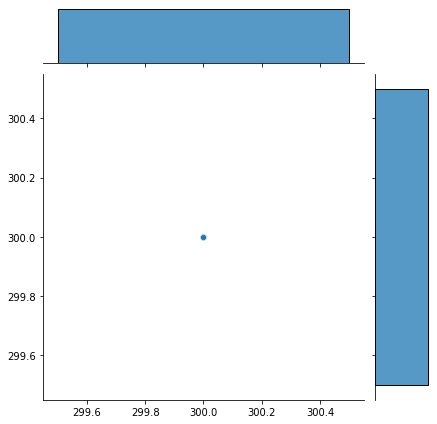

In [8]:
dim1 = []
dim2 = []
for image_filename in os.listdir(train_dir+'paper'):
    
    img = mpimg.imread(train_dir+'paper'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

sns.jointplot(dim1,dim2)

print("Height: ",np.mean(dim1))
print("Width: ",np.mean(dim2))

In [9]:
image_paths = list(paths.list_images("rps"))
np.random.shuffle(image_paths)
image_paths[:5]

['rps/paper/paper07-077.png',
 'rps/rock/rock05ck01-115.png',
 'rps/rock/rock02-034.png',
 'rps/paper/paper04-038.png',
 'rps/scissors/scissors01-076.png']

In [10]:
labels = []
for image_path in image_paths:
    label = image_path.split("/")[1]
    labels.append(label)
class_count = Counter(labels) 
pprint(class_count)

Counter({'paper': 840, 'rock': 840, 'scissors': 840})


In [11]:
BATCH_SIZE = 128
EPOCHS = 20
IMG_SIZE = 150
NUM_CLASSES=3

In [12]:
training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')


validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	train_dir,
	target_size=(IMG_SIZE,IMG_SIZE),
	class_mode='categorical',
    batch_size=BATCH_SIZE
)

validation_generator = validation_datagen.flow_from_directory(
	test_dir,
	target_size=(IMG_SIZE,IMG_SIZE),
	class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [13]:
train_generator.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [14]:
def training_model():
    model = Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        # The second convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # The third convolution
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # The fourth convolution
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')                       
    ])
    return model

In [15]:
model = training_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [ ]:
#Compile the Model
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

#Train the Model
history = model.fit(train_generator, epochs=EPOCHS, steps_per_epoch=20, validation_data = validation_generator, validation_steps=3, batch_size=BATCH_SIZE)

Epoch 1/20
20/20 [==============================] - 153s 8s/step - loss: 1.7003 - accuracy: 0.3536 - val_loss: 1.0951 - val_accuracy: 0.3333
Epoch 2/20
20/20 [==============================] - 153s 8s/step - loss: 1.0960 - accuracy: 0.3595 - val_loss: 1.0696 - val_accuracy: 0.4785
Epoch 3/20
20/20 [==============================] - 150s 7s/step - loss: 1.1020 - accuracy: 0.4036 - val_loss: 1.0408 - val_accuracy: 0.5242
Epoch 4/20
20/20 [==============================] - 149s 7s/step - loss: 1.0467 - accuracy: 0.4556 - val_loss: 0.8936 - val_accuracy: 0.6102
Epoch 5/20
20/20 [==============================] - 149s 7s/step - loss: 1.0187 - accuracy: 0.4964 - val_loss: 0.8999 - val_accuracy: 0.6156
Epoch 6/20
20/20 [==============================] - 148s 7s/step - loss: 0.9641 - accuracy: 0.5206 - val_loss: 0.8297 - val_accuracy: 0.6774
Epoch 7/20
20/20 [==============================] - 147s 7s/step - loss: 0.9196 - accuracy: 0.5690 - val_loss: 0.7126 - val_accuracy: 0.8091
Epoch 8/20
20

In [ ]:
test_loss, test_acc = model.evaluate(validation_generator, verbose=1)
print('Test Accuracy:', test_acc)
print('Test Loss:', test_loss)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='lower right')
plt.title('accuracy plot - train vs test')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'], loc = 'upper right')
plt.title('loss plot - training vs validation')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

In [ ]:
model.save('rps_model')
model.save('rps.h5')

In [ ]:
!du -lh rps_model

In [ ]:
convert_bytes(get_file_size('rps.h5'), "MB")

In [ ]:
!tar cvf rps.tar.gz rps_model rps.h5

In [ ]:
quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

q_aware_model.summary()

In [ ]:
q_aware_model.fit(train_generator, epochs=20, validation_data = validation_generator, batch_size=256)

In [ ]:
q_aware_model_loss, q_aware_model_accuracy = q_aware_model.evaluate(validation_generator, verbose=1)
print('Quant Test Accuracy:', q_aware_model_accuracy)
print('Quant Test Loss:', q_aware_model_loss)

In [ ]:
TF_LITE_MODEL_FILE_NAME = 'tf_lite_model_rps.tflite'

tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

In [ ]:
TF_LITE_QUANT_MODEL_FILE_NAME = 'tf_lite_quant_model_rps.tflite'

tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = tf_lite_converter.convert()

tflite_model_name = TF_LITE_QUANT_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

In [ ]:
convert_bytes(get_file_size('tf_lite_model_rps.tflite'), "MB")
convert_bytes(get_file_size('tf_lite_quant_model_rps.tflite'), "MB")

In [ ]:
images, labels = (next(iter(validation_generator)))

In [ ]:
print(images.shape)
print(images.dtype)

In [ ]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

In [ ]:
interpreter.resize_tensor_input(input_details[0]['index'], (128, 150, 150, 3))
interpreter.resize_tensor_input(output_details[0]['index'], (128, 3))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

In [ ]:
interpreter.set_tensor(input_details[0]['index'], images)
interpreter.invoke()

tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])

print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)
expected_classes = np.argmax(labels, axis=1)

acc = accuracy_score(prediction_classes, expected_classes)
print('Test accuracy TFLITE model :', acc)

In [ ]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_QUANT_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

In [ ]:
interpreter.resize_tensor_input(input_details[0]['index'], (128, 150, 150, 3))
interpreter.resize_tensor_input(output_details[0]['index'], (128, 3))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

In [ ]:
interpreter.set_tensor(input_details[0]['index'], images)
interpreter.invoke()

tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])

print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)
expected_classes = np.argmax(labels, axis=1)

acc = accuracy_score(prediction_classes, expected_classes)
print('Test accuracy TFLITE model :', acc)